In [1]:
%load_ext autoreload
%autoreload 2

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from utils import eval_numerical_gradient, eval_numerical_gradient_array, rel_error

In [8]:
data = pd.read_csv("data/data6.csv", sep='\\s+', names=["x1", "x2", "y"])

In [9]:
data

,x1,x2,y
0,1.699885,1.546782,1
1,1.641367,2.506392,1
2,2.408797,1.430931,1
3,3.255215,1.792221,1
4,2.361248,1.980791,1
...,...,...,...
355,0.007796,3.741013,1
356,-2.405753,2.000000,1
357,2.373454,4.619262,1
358,-1.056150,2.000000,1


## EDA

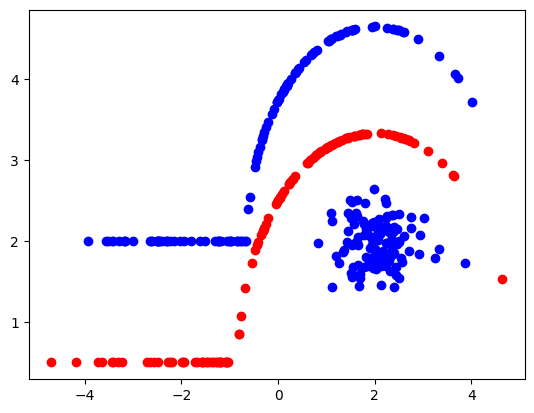

In [10]:
blue = data[data.y == 1]
red = data[data.y == 0]
plt.scatter(blue.x1, blue.x2, color="blue")
plt.scatter(red.x1, red.x2, color="red")
plt.show()

## Layers

Abstract class for all layers

In [95]:
from typing import Any
import abc

class Layer(abc.ABC):
    def __init__(self):
        # will be used for backward step
        self.cache = {}
    
    @abc.abstractmethod
    def forward(self):
        pass

    @abc.abstractmethod
    def backward(self):
        pass

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

In [96]:
class Linear(Layer):
    def __init__(self, n_in, n_out, w_scale=1e-3) -> None:
        super().__init__()
        self.weight = np.random.normal(0, w_scale, size=(n_in, n_out))
        self.bias = np.zeros(n_out)
        self.n_in = n_in
        self.n_out = n_out

    def forward(self, x) -> Any:
        self.cache['x'] = x  

        out = x @ self.weight + self.bias

        return out

    def backward(self, grad_upstream):
        x = self.cache['x']

        dx = (grad_upstream @ self.weight.T).reshape(-1, *x.shape[1:])
        dw = x.reshape(x.shape[0], -1).T @ grad_upstream
        db = grad_upstream.sum(axis=0)

        return {
            "dx": dx,
            "dw": dw,
            "db": db,
        } 


# test linear layer
np.random.seed(42)  # For reproducibility
n_in, n_out, batch_size = 3, 2, 4
layer = Linear(n_in, n_out)
x = np.random.randn(batch_size, n_in)
grad_upstream = np.random.randn(batch_size, n_out)

out = layer(x)
grads = layer.backward(grad_upstream)

num_dx = eval_numerical_gradient_array(lambda x: layer(x), x, grad_upstream)
print("dx rel error: ", rel_error(num_dx, grads["dx"]))

def loss_w(l, w):
    l.weight = w
    return layer(x) 
num_grad_w = eval_numerical_gradient_array(lambda w: loss_w(deepcopy(layer), w), layer.weight, grad_upstream)
print("dw rel error", rel_error(num_grad_w, grads["dw"]))

def loss_b(l, b):
    l.bias = b
    return l(x) 
num_grad_b = eval_numerical_gradient_array(lambda b: loss_b(deepcopy(layer), b), layer.bias, grad_upstream)
print("db rel error", rel_error(num_grad_b, grads["db"]))

dx rel error:  9.614152067053775e-12
dw rel error 1.8133642735544222e-15
db rel error -2.1593837828959295e-14


In [97]:
class ReLU(Layer):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        self.cache["x"] = x
        return (x > 0) * x

    def backward(self, grad_upstream):
        x = self.cache["x"]

        return {
            "dx": (x > 0) * grad_upstream
        }


# test relu
np.random.seed(42)  # For reproducibility
batch_size, n_in = 4, 3
layer = ReLU()
x = np.random.randn(batch_size, n_in) 
grad_upstream = np.random.randn(batch_size, n_in) 

out = layer(x)
grads = layer.backward(grad_upstream)

num_dx = eval_numerical_gradient_array(lambda x: layer(x), x, grad_upstream)
print("dx rel error:", rel_error(grads["dx"], num_dx))

dx rel error: -3.739601221279069e-14


In [98]:
def softmax_loss(x, y):
    loss, dx = None, None
    N, C = x.shape
    x1 = x - x.max(axis=1, keepdims=True)

    p = np.exp(x1) / np.exp(x1).sum(axis=1, keepdims=True)

    loss = -np.log(p[np.arange(N), y]).mean()

    dldx = p
    dldx[np.arange(N), y] -= 1
    dx = dldx / N

    return loss, dx

# test loss grad
np.random.seed(44)
batch_size, n_classes = 3, 4
x = np.random.normal(size=(batch_size, n_classes))
y = np.random.normal(size=(batch_size, n_classes)).argmax(axis=-1)

loss, dx = softmax_loss(x, y)
num_dx = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, h=1e-3)
print("dx rel error: ", rel_error(dx, num_dx))

dx rel error:  -6.559217162934357e-08


## Network

In [216]:
class Net(Layer):
    def __init__(self, weight_scale=1e-3):
        super().__init__()
        self.layers = [
            Linear(2, 5, weight_scale),
            ReLU(),
            Linear(5, 5, weight_scale),
            ReLU(),
            Linear(5, 2, weight_scale)
        ]
    
    def forward(self, x):
        z = x
        for layer in self.layers:
            z = layer(z)
        
        return z
    
    def backward(self, grad_upstream, lr=1e-3) -> None:
        n = len(self.layers)
        for i in range(n):
            idx = n - 1 - i
            grads = self.layers[idx].backward(grad_upstream)
            grad_upstream = grads["dx"]

            if isinstance(self.layers[idx], Linear):
                self.layers[idx].weight -= lr * grads["dw"]
                self.layers[idx].bias -= lr * grads["db"]

In [234]:
np.random.seed(1234)
net = Net(weight_scale=1)

In [218]:
logits = net(data[["x1", "x2"]])
pred = np.argmax(logits.to_numpy(), axis=-1)
pred

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,

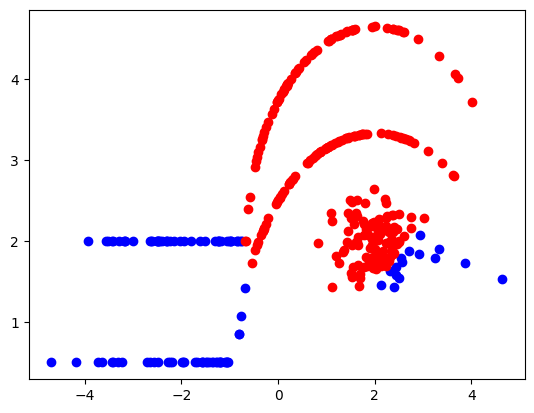

In [219]:
blue = data[pred == 1]
red = data[pred == 0]
plt.scatter(blue.x1, blue.x2, color="blue")
plt.scatter(red.x1, red.x2, color="red")
plt.show()

## Training

In [221]:
from tqdm.auto import tqdm

/home/evgeniy/programming/study/univ/stat_algos/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [235]:
np.random.seed(1234)
net = Net(weight_scale=1)

In [240]:
n_iter = 10000
lr = 1e-2

loss_history = {}

for i in tqdm(range(n_iter)):
    logits = net(data[["x1", "x2"]].to_numpy())
    y = data["y"].to_numpy()
    loss, dx = softmax_loss(logits, y)
    loss_history[i] = loss
    
    net.backward(dx, lr=lr)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:09<00:00, 1014.36it/s]


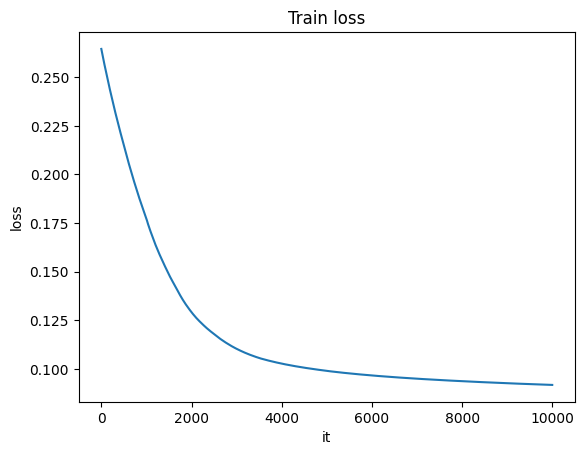

In [249]:
plt.plot(list(loss_history.keys()), list(loss_history.values()))
plt.xlabel("it")
plt.ylabel("loss")
plt.title("Train loss")
plt.show()

In [242]:
logits = net(data[["x1", "x2"]])
pred = np.argmax(logits.to_numpy(), axis=-1)

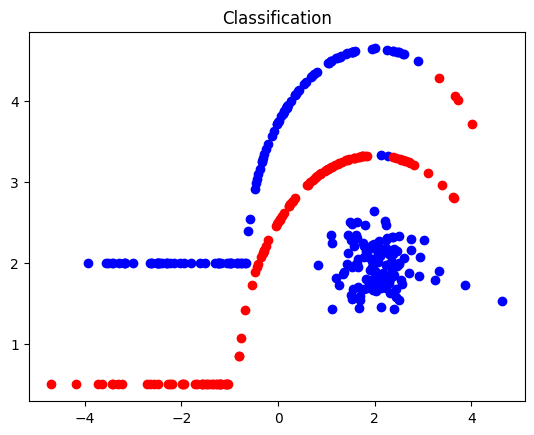

In [250]:
blue = data[pred == 1]
red = data[pred == 0]
plt.scatter(blue.x1, blue.x2, color="blue")
plt.scatter(red.x1, red.x2, color="red")
plt.title("Classification")
plt.show()

In [247]:
print(f"Train accuracy: {(data["y"] == pred).mean() * 100:.2f}%")

Train accuracy: 98.06%
